In [35]:
import pandas as pd
import csv
import os
import numpy as np
import datetime
from xlsxwriter.workbook import Workbook
from xlsxwriter import Workbook
import time
from scipy import integrate, stats
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import preprocessing

# %matplotlib inline

In [2]:
Working_dir = os.getcwd()
Data_dir = os.path.join(Working_dir, 'Raw data')
Data_prep_dir = os.path.join(Working_dir, 'Preprocessed data')
Output_dir = os.path.join(Working_dir, 'Analysis')

In [3]:
nodes_file_names = ['May2018_idle.csv' , 'June2018_idle.csv', 'July2018_idle.csv', \
                    'September2018.csv', 'October2018.csv', 'November2018.csv', \
                    'December2018.csv' , 'January2019.csv']

In [4]:
nodes_df_names = [item.split('.')[0] for item in nodes_file_names]

## Preprocessing - all the months

In [16]:
for file_name in nodes_file_names:
    node_df = pd.read_csv( os.path.join( Data_dir, file_name), delimiter=";", header=0 )
    node_df.dcenergy = node_df.dcenergy.apply(lambda x: float(x.replace(",", ".")) )

    node_df["timestamp_py"] = node_df["tempo"].\
        apply(lambda x: datetime.datetime.strptime(x, '%a %d %b %H:%M:%S CEST %Y') if 'CEST' in x \
              else datetime.datetime.strptime(x, '%a %d %b %H:%M:%S CET %Y'))
        
    node_df.iloc[:,3:-1] = node_df.iloc[:, 3:-1].\
        apply(lambda y: y.\
                apply(lambda x: \
                      float(x.replace(",", ".")) if type(x)==str else x ))
    node_df.to_csv(path_or_buf=os.path.join( Data_prep_dir, file_name), sep=';', index=False)

## Energy analysis - calculations

In [7]:
def forth_integral(node, time, power=['cpu', 'mem', 'sys']):
    power_kw = node[power + '_power'][1:].values/1000.0
    return(np.dot(power_kw, time))

In [8]:
def error_percentage(a, b):
    if a > 0.:
        return(abs(a-b) / a * 100.)
    else: 
        return(abs(a-b) / b * 100.)

In [9]:
def percentage(a, b):
    return(a / b * 100.)

In [ ]:
nodes_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    
    node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
    
    nodes_df_dict[df_name] = pd.DataFrame(columns = list(node_df.nodename.unique()), \
                                          index = ['total_dcenergy', 'sys_energy', \
                                                   'cpu_energy', 'mem_energy', 'other_energy', \
                                                   'cpu_en_percent', 'mem_en_percent', \
                                                   'other_en_percent', 'sys_util', 'mem_util', 'cpu_util', \
                                                   'other_util','sys_power_max', 'cpu_power_max',\
                                                   'mem_power_max', 'dcenergy_error_percent'], data=0)
    
    for node in nodes_df_dict[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()
        time_difference = (one_node_df["timestamp_measure"][1:].values -\
            one_node_df["timestamp_measure"][:-1].values)/3600.0

        for util_type in ['cpu', 'mem', 'sys']:
            # Integrate system power over time
            nodes_df_dict[df_name].loc[util_type + '_energy', node] = forth_integral(node=one_node_df, \
                                                                                     time=time_difference, \
                                                                                     power=util_type)
            # Find max power utilization by CPU, mem and system
            max_val = one_node_df.loc[:,util_type + '_power'].max() 
            if nodes_df_dict[df_name].loc[util_type + '_power_max', node] < max_val:
                nodes_df_dict[df_name].loc[util_type + '_power_max', node] = max_val
        
        # Energy meter rise
        nodes_df_dict[df_name].loc["total_dcenergy", node] = \
            node_df[node_df.nodename == node]["dcenergy"].values[-1] - \
            node_df[node_df.nodename == node]["dcenergy"].values[0]
    
        # Integral of sys power vs dcenergy meter error in %
        nodes_df_dict[df_name].loc["dcenergy_error_percent", node] = \
            error_percentage(nodes_df_dict[df_name].loc["total_dcenergy",node], \
                             nodes_df_dict[df_name].loc["sys_energy", node])
            
    # Energy used for purposes other than CPU and memory
    nodes_df_dict[df_name].loc["other_energy", :] = nodes_df_dict[df_name].loc["sys_energy", :] - \
        nodes_df_dict[df_name].loc["cpu_energy", :] - nodes_df_dict[df_name].loc["mem_energy", :]
        
    # Energy portion used for CPU and memory in overall the system energy consumption
    for util_type in ['cpu', 'mem', 'other']:
        nodes_df_dict[df_name].loc[util_type + '_en_percent', :] = \
            percentage(nodes_df_dict[df_name].loc[util_type + '_energy',:], nodes_df_dict[df_name].loc["sys_energy", :])
    
    nodes_df_dict[df_name].to_csv( path_or_buf=os.path.join( Output_dir, 'nodes_stats_' + file_name), sep=';' )    
    print(df_name)

## Energy analysis

In [26]:
nodes_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_df_dict[df_name]  = pd.read_csv( os.path.join( Output_dir, 'nodes_stats_' + file_name), \
                                          delimiter=";", header=0, index_col=0 )

### Errors in DC energy meter over months

In [35]:
dcenergy_error_nodes_dict = {}
dcenergy_all_error_nodes = []
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    dcenergy_error_nodes_dict[df_name] = np.where(nodes_df_dict[df_name].loc["dcenergy_error_percent", :] > 5.)[0]
    
    node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
    
    for node in nodes_df_dict[df_name].iloc[:, dcenergy_error_nodes_dict[df_name] ].columns.values:
        int_name = int(node.split('x')[-1])
        if not(int_name in dcenergy_all_error_nodes):
            dcenergy_all_error_nodes.append(int_name)

In [36]:
list(set(dcenergy_all_error_nodes))

[1,
 2,
 4,
 5,
 7,
 9,
 10,
 11,
 12,
 13,
 15,
 16,
 18,
 20,
 21,
 23,
 24,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 42,
 44,
 45,
 47,
 52,
 53,
 54,
 55,
 58,
 59,
 60,
 61,
 64,
 65,
 66,
 67,
 68,
 71,
 72,
 73,
 77,
 78,
 79,
 82,
 83,
 91,
 92,
 93,
 94,
 96,
 98,
 100,
 101,
 102,
 105,
 107,
 108,
 112,
 115,
 117,
 118,
 119,
 120,
 121,
 124,
 127,
 131,
 134,
 135,
 137,
 139,
 140,
 141,
 146,
 150,
 151,
 154,
 158,
 160,
 162,
 163,
 164,
 169,
 170,
 172,
 173,
 175,
 176,
 177,
 179,
 181,
 182,
 187,
 191,
 195,
 197,
 198,
 203,
 204,
 206,
 208,
 210,
 211,
 213,
 215,
 216]

In [ ]:
with open(os.path.join( Output_dir,'dcenergy_error_nodes.txt'), "w") as f:
    f.write(str(list(set(dcenergy_all_error_nodes))))

In [ ]:
with open(os.path.join( Output_dir,'dcenergy_error_nodes.csv'),'w') as f:
    w = csv.writer(f)
    w.writerows(dcenergy_error_nodes_dict.keys(), dcenergy_error_nodes_dict)

In [ ]:
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_stats = pd.read_csv( os.path.join( Output_dir, 'nodes_stats_'+file_name), delimiter=";", header=0 )
    node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
    for node in nodes_stats.iloc[:, dcenergy_error_nodes_dict[df_name]+1 ].columns.values:
        int_name = int(node.split('x')[-1])
        node_df[node_df.nodename == node].\
            plot(x='timestamp_py', y='dcenergy', title=df_name+'\nNode '+str(int_name)+' dc_energy')

### Max CPU, system and memory power utilization of nodes over all months

In [ ]:
node_max_power = pd.DataFrame(columns = node_names, \
                              index = ['cpu_power_max', 'mem_power_max', 'sys_power_max'], \
                              data=0)
for file_name in nodes_file_names:
    nodes_stats = pd.read_csv( os.path.join( Output_dir, 'nodes_stats_'+file_name), \
                              delimiter=";", header=0, index_col=0 )
    print(file_name)
    for node in node_names:
        for util_type in ['cpu', 'mem', 'sys']:
            max_val = nodes_stats.loc[util_type + '_power_max', node]
            if node_max_power.loc[util_type + '_power_max', node] < max_val:
                node_max_power.loc[util_type + '_power_max', node] = max_val
                              

In [ ]:
print('Max system power use observed: \t', node_max_power.loc['sys_power_max',:].max(), \
      '\nMax CPU power use observed: \t', node_max_power.loc['cpu_power_max',:].max(), \
      '\nMax memory power use observed: \t', node_max_power.loc['mem_power_max',:].max())

In [ ]:
node_max_power.to_csv( path_or_buf=os.path.join( Output_dir, 'node_max_power_all_months.csv'), sep=';') 

## Pie-charts with energy portions used by CPU, memory and other sources

In [10]:
nodes_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_df_dict[df_name] = pd.read_csv(os.path.join( Output_dir, 'nodes_stats_' + file_name), \
                                         delimiter=";", header=0, index_col=0)
    to_drop_ix = np.unique(np.append(\
                                     np.where(nodes_df_dict[df_name].loc["dcenergy_error_percent", :].isna())[0], \
                                     np.where(nodes_df_dict[df_name].loc["dcenergy_error_percent", :] > 5.)[0]))
    to_drop = nodes_df_dict[df_name].iloc[:,to_drop_ix].columns.values
    nodes_df_dict[df_name].drop(columns=to_drop, inplace=True)

In [11]:
def plot_energy_cons(data, node, month, year, avg_flag=False):
    labels = 'CPU', 'Memory', 'Other'
    data = data.values
    colors = ['lightskyblue', 'lightcoral',  'yellowgreen']# 'gold', 
    
    fig1, ax1 = plt.subplots()
    plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
    plt.axis('equal')
    if not avg_flag:
        plt.title(month + ' ' + year + ', Node '+ node)
        fig1.savefig(os.path.join( Output_dir, 'Plots', 'Node_' + node + '_' + month + '_' + year + '.png' ) )
    else:
        plt.title(month + ' ' + year)
        fig1.savefig(os.path.join( Output_dir, 'Plots', 'Avg_' + month + '_' + year + '.png' ) )
        plt.show()

In [1]:
for df_name in nodes_df_names:
    year = re.findall(r'\d+', df_name)[0]
    month = df_name.split(year)[0]
#     for node in nodes_df_dict[df_name].columns.values:
#         plot_energy_cons(data=nodes_df_dict[df_name][node][5:8], \
#                          node=str(int(node.split('x')[1])), \
#                          month=month, year=year)
    plot_energy_cons(data=nodes_df_dict[df_name].iloc[5:8,:].mean(axis=1), \
                     node='', \
                     month=month, year=year, avg_flag=True)
    

NameError: name 'nodes_df_names' is not defined

## Temperature, fans speed and CPU power trends - September

In [37]:
nodes_stats_Sept = pd.read_csv(os.path.join( Output_dir, 'nodes_stats_September2018.csv'), \
                                         delimiter=";", header=0, index_col=0)
to_drop_ix = np.unique(np.append(\
                                     np.where(nodes_stats_Sept.loc["dcenergy_error_percent", :].isna())[0], \
                                     np.where(nodes_stats_Sept.loc["dcenergy_error_percent", :] > 5.)[0]))
to_drop = nodes_stats_Sept.iloc[:,to_drop_ix].columns.values
node_df_Sept = pd.read_csv(os.path.join( Data_prep_dir, 'September2018.csv'), \
                                         delimiter=";", header=0)
for node in to_drop:
    node_df_Sept.drop(index=node_df_Sept[node_df_Sept.nodename == node].index)

In [38]:
node_df_Sept.head()

,nodename,tempo,timestamp_measure,sys_power,cpu_power,mem_power,fan1a,fan1b,fan2a,fan2b,...,cpu_util,mem_util,io_util,amb_temp,cpu1_temp,cpu2_temp,exh_temp,sysairflow,dcenergy,timestamp_py
0,cresco6x001,Tue 4 Sep 11:49:25 CEST 2018,1536054565,150,110,13,4480,4736,5632,6528,...,0,0,0,17,44,39,32,17,666.57519,2018-09-04 11:49:25
1,cresco6x002,Tue 4 Sep 11:49:26 CEST 2018,1536054565,150,110,12,4608,4224,6272,5376,...,0,0,0,18,46,40,38,17,680.75820,2018-09-04 11:49:26
2,cresco6x003,Tue 4 Sep 11:49:26 CEST 2018,1536054565,180,140,12,4608,4736,6016,6144,...,0,0,0,18,55,45,36,17,736.81701,2018-09-04 11:49:26
3,cresco6x004,Tue 4 Sep 11:49:27 CEST 2018,1536054565,150,110,10,4608,4224,6272,5376,...,0,0,0,17,46,38,32,13,334.46734,2018-09-04 11:49:27
4,cresco6x005,Tue 4 Sep 11:49:27 CEST 2018,1536054565,180,140,13,4864,5120,5760,6144,...,0,0,0,17,45,40,33,19,414.79655,2018-09-04 11:49:27


In [18]:
stats.spearmanr(a=node_df_Sept.exh_temp.values, b=node_df_Sept.cpu_power.values)

SpearmanrResult(correlation=0.3486975817138365, pvalue=0.0)

### Normalize and recheck

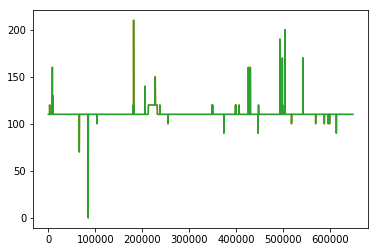

In [17]:
plt.plot(node_Sept.cpu_power)
plt.show()

In [67]:
round(node_Sept_norm.exh_temp, 1)

0         0.7
215       0.7
430       0.9
645       0.8
860       0.8
1075      0.7
1290      0.7
1505      0.8
1720      0.8
1935      0.7
2150      0.7
2365      0.7
2580      0.8
2795      0.8
3010      0.8
3225      0.7
3440      0.7
3655      0.8
3870      0.8
4085      0.8
4300      0.7
4515      0.7
4730      0.7
4945      0.7
5160      0.8
5375      0.8
5590      0.8
5805      0.8
6020      0.7
6235      0.8
         ... 
642205    0.8
642420    0.8
642635    0.8
642850    0.8
643065    0.8
643280    0.8
643495    0.8
643710    0.8
643925    0.8
644140    0.8
644355    0.9
644570    0.9
644785    0.9
645000    0.8
645215    0.8
645430    0.9
645645    0.9
645860    0.9
646075    0.8
646290    0.8
646505    0.8
646720    0.8
646935    0.8
647150    0.8
647365    0.8
647580    0.8
647795    0.9
648010    0.8
648225    0.8
648440    0.8
Name: exh_temp, Length: 3017, dtype: float64

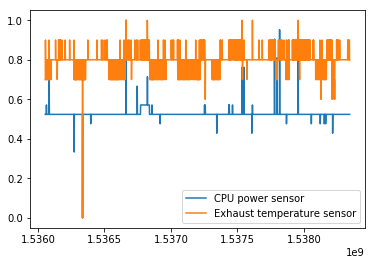

In [68]:
node_Sept_norm = node_df_Sept[node_df_Sept.nodename == node_df_Sept.nodename.unique()[0]].copy()

node_Sept_norm.loc[:,['cpu_power', 'exh_temp']] = \
    preprocessing.normalize(node_Sept_norm.loc[:,['cpu_power', 'exh_temp']], norm='max', axis=0)
node_Sept_norm.exh_temp = round(node_Sept_norm.exh_temp, 1)
# plt.plot('timestamp_measure', \
#          preprocessing.normalize(node_Sept_norm.loc[:,['cpu_power', 'exh_temp']], norm='max', axis=0))
plt.plot('timestamp_measure','cpu_power', data=node_Sept_norm, label='CPU power sensor')
plt.plot('timestamp_measure','exh_temp', data=node_Sept_norm, label='Exhaust temperature sensor')
plt.legend()
plt.show()

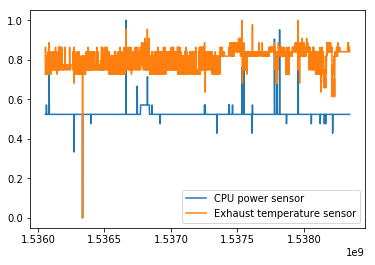

In [33]:
node_Sept_norm = node_df_Sept[node_df_Sept.nodename == node_df_Sept.nodename.unique()[0]].copy()
# node_Sept.plot(x='timestamp_py', y='cpu_power', label='CPU power sensor', linestyle='-')
# node_Sept.plot(x='timestamp_py', y='exh_temp', label='CPU power sensor', linestyle='-')
cpu_min = node_Sept_norm.cpu_power.min()
cpu_max = node_Sept_norm.cpu_power.max()
node_Sept_norm.cpu_power = node_Sept_norm.cpu_power.apply(lambda x: (x-cpu_min)/(cpu_max-cpu_min))



exh_temp_min = node_Sept_norm.exh_temp.min()
exh_temp_max = node_Sept_norm.exh_temp.max()
node_Sept_norm.exh_temp = node_Sept_norm.exh_temp.apply(lambda x: (x-exh_temp_min)/(exh_temp_max-exh_temp_min))


plt.plot('timestamp_measure', 'cpu_power', data=node_Sept_norm, label='CPU power sensor')
plt.plot('timestamp_measure', 'exh_temp', data=node_Sept_norm, label='Exhaust temperature sensor')

# plt.plot('timestamp_measure', 'cpu1_temp', data=node_Sept, label='CPU1 temp')
# plt.plot('timestamp_measure', 'cpu2_temp', data=node_Sept, label='CPU2 temp')
plt.legend()
plt.show()

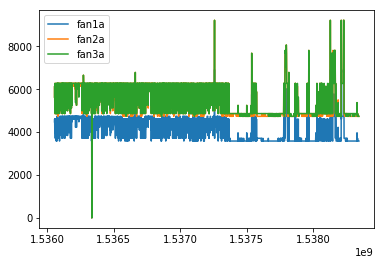

In [19]:
node_Sept = node_df_Sept[node_df_Sept.nodename == node_df_Sept.nodename.unique()[0]]
plt.plot('timestamp_measure', 'fan1a', data=node_Sept, label='fan1a')
plt.plot('timestamp_measure', 'fan2a', data=node_Sept, label='fan2a')
plt.plot('timestamp_measure', 'fan3a', data=node_Sept, label='fan3a')
plt.legend()
plt.show()

In [33]:
node_Sept

,nodename,tempo,timestamp_measure,sys_power,cpu_power,mem_power,fan1a,fan1b,fan2a,fan2b,...,cpu_util,mem_util,io_util,amb_temp,cpu1_temp,cpu2_temp,exh_temp,sysairflow,dcenergy,timestamp_py
0,cresco6x001,Tue 4 Sep 11:49:25 CEST 2018,1536054565,150,110,13,4480,4736,5632,6528,...,0,0,0,17,44,39,32,17,666.57519,2018-09-04 09:49:25
215,cresco6x001,Tue 4 Sep 12:01:23 CEST 2018,1536055283,150,110,13,4608,4736,6144,6400,...,0,0,0,17,45,39,32,17,666.60428,2018-09-04 10:01:23
430,cresco6x001,Tue 4 Sep 12:13:15 CEST 2018,1536055995,150,110,12,4224,4224,5120,5376,...,0,0,0,18,44,39,38,17,666.63312,2018-09-04 10:13:15
645,cresco6x001,Tue 4 Sep 12:25:00 CEST 2018,1536056700,150,110,12,3968,4096,4864,5120,...,0,0,0,17,44,39,36,17,666.66174,2018-09-04 10:25:00
860,cresco6x001,Tue 4 Sep 12:36:48 CEST 2018,1536057408,150,110,12,4608,4736,6272,6528,...,0,0,0,17,44,39,36,13,666.69040,2018-09-04 10:36:48
1075,cresco6x001,Tue 4 Sep 12:48:36 CEST 2018,1536058116,150,110,13,4352,4352,5888,6016,...,0,0,0,17,45,39,32,13,666.71908,2018-09-04 10:48:36
1290,cresco6x001,Tue 4 Sep 13:00:23 CEST 2018,1536058823,150,110,12,4608,4736,5888,6144,...,0,0,0,17,44,39,32,13,666.74771,2018-09-04 11:00:23
1505,cresco6x001,Tue 4 Sep 13:12:09 CEST 2018,1536059529,150,110,12,3712,3840,4864,5120,...,0,0,0,18,45,39,33,17,666.77635,2018-09-04 11:12:09
1720,cresco6x001,Tue 4 Sep 13:23:54 CEST 2018,1536060234,150,110,13,3712,4224,4992,5376,...,0,0,0,17,44,39,36,17,666.80488,2018-09-04 11:23:54
1935,cresco6x001,Tue 4 Sep 13:35:39 CEST 2018,1536060939,150,110,13,4608,4736,6016,6400,...,0,0,0,17,45,39,32,17,666.83342,2018-09-04 11:35:39


## Further analysis
- normalize and correlate fans and CPU power ranges
- investigate on temperature fluctuations
- think of how to work with all the nodes